<a href="https://colab.research.google.com/github/vujjiniashrith/ESS-profit-maximization-using-deep-Reinforcement-Learning/blob/main/gym_environment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gym
import random
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from gym import Env
from gym import spaces
from gym.spaces import Discrete, Box

In [ ]:
data_elec = pd.read_csv("electicity_data_hourly.csv")
data_cons = pd.read_csv("consumer_data_hourly.csv")
print(data_elec.columns)
print(data_cons.columns)

Index(['datetime', 'system_energy_price_da'], dtype='object')
Index(['dateTime', 'use'], dtype='object')


In [ ]:
data_elec.rename(columns={'system_energy_price_da':'price'},inplace = True)

In [ ]:
scaler = MinMaxScaler()
data_elec['price'] = scaler.fit_transform(data_elec[['price']])

In [ ]:
data_elec.head()

,datetime,price
0,2022-01-01 00:00:00,0.016487
1,2022-01-01 01:00:00,0.010621
2,2022-01-01 02:00:00,0.009897
3,2022-01-01 03:00:00,0.009987
4,2022-01-01 04:00:00,0.008968


In [ ]:
data_cons.rename(columns={'use':'usage'},inplace = True)
print(data_cons.usage.max()," ",data_cons.usage.min())
print(data_elec.price.max()," ",data_elec.price.min())

29.8692   0.0
1.0   0.0


In [ ]:
split_point = 7027
train_elec = data_elec[:split_point]
train_cons = data_cons[:split_point]
test_elec = data_elec[split_point:]
test_cons = data_cons[split_point:]
print(train_elec.shape, test_elec.shape)
print(train_cons.shape, test_cons.shape)

(7027, 2) (1710, 2)
(7027, 2) (1757, 2)


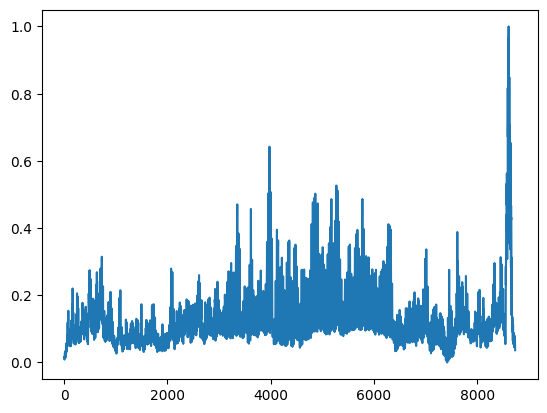

In [ ]:
plt.plot(data_elec.price)

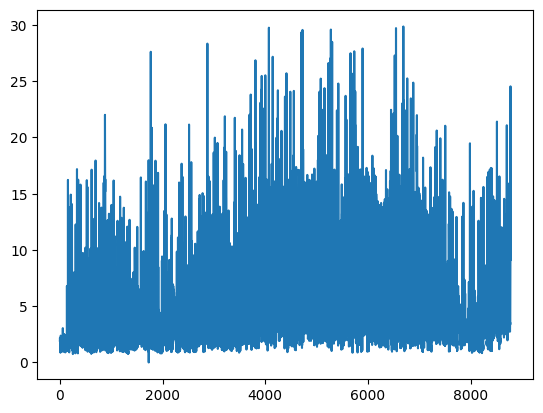

In [ ]:
plt.plot(data_cons.usage)

In [ ]:
data_usage = data_cons['usage'].values
data_price = data_elec['price'].values

# Custom Environment for smartGrid


In [ ]:
class SmartGrid(Env):
    def __init__(self, data_usage, data_price, max_capacity):
        # Load the electricity and consumer usage
        self.data_price = data_price
        self.data_usage = data_usage

        # Set maximum capacity
        self.max_capacity = max_capacity

        # Set action space
        self.action_space = spaces.Box(low=np.array([-3]), high=np.array([3]))

        # Set observation space
        self.observation_space = spaces.Dict({
            'curr_capacity': spaces.Box(low=0, high=self.max_capacity, shape=(1,), dtype=np.float64),
            'curr_price': spaces.Box(low=0, high=1, shape=(1,), dtype=np.float64),
            'cons_demand': spaces.Box(low=0, high=30, shape=(1,), dtype=np.float64)
        })
        #horizon- total time for which our code runs
        self.horizon = 100

        #this tells us the present_capcity of our battery, also the first component of the observation_space
        self.present_capacity = 0

        #this keeps track of all the time_steps and keeps it below horizon
        self.curr_pos = 0

        #done flag, if curr_pos>horizon initialize the done flag
        self.done = False

        #this keeps track of curr_profits
        self.profits = 0

        #all four below are for rendering the information
        self.action_history = []
        self.profits_history = []
        self.reward_history = []
        self.current_capacity = []

    def step(self, action):
        curr_profits = self.profits

         #increment the current position
        self.curr_pos += 1
        if self.curr_pos >= self.horizon:
            self.done = True

        #update the capacity of the battery
        # 0-3 is selling where 0 means selling 3 units of electricity
        # 3 is being idle
        # 3-0 is buying the electricity from the grid
        self.present_capacity += action - 3

        #update the profits
        self.profits += self.find_profits(action)

        #profits of the current step
        curr_profits = self.profits - curr_profits

        #calculate the
        step_reward = self.calculate_reward(curr_profits, action)

        info = {}

        observation = {
            'curr_capacity': self.present_capacity,  # Use 'self.present_capacity' here
            'curr_price': self.data_price[self.curr_pos],  # Use 'self.data_price' and 'self.curr_pos' here
            'cons_demand': 0
        }

        # Save all the info
        self.action_history.append(action)
        self.profits_history.append(curr_profits)
        self.reward_history.append(step_reward)

        return observation, step_reward, self.done, info

    def reset(self):
        self.done = False
        self.curr_pos = 0
        self.present_capacity = 0
        self.profits = 0
        self.action_history = []
        self.profits_history = []
        self.reward_history = []
        self.current_capacity = []

    def calculate_reward(self, curr_profits, action):
        reward = 0
        if action - 3 < 0:
            reward = curr_profits * 10 + self.punishment_for_bad_action(action)  # Use 'self.punishment_for_bad_action'
        elif action == 0:
            reward = 0
        else:
            reward = curr_profits * 10 + self.punishment_for_bad_action(action)  # Use 'self.punishment_for_bad_action'
        return reward

    def punishment_for_bad_action(self, action):
        punishment = 0

        #criteria for bad choices and assign a punishment
        if action <3:
            if self.present_capacity < 3 - action:
                # Penalize actions that attempt to discharge more than available
                punishment = -5
        elif action >3:
            if self.present_capacity > self.max_capacity - (action - 3):
                # Penalize actions that attempt to charge beyond capacity
                punishment = -5
        return punishment

    def find_profits(self, action):
        step_transaction = 0
        step_transaction = -(action - 3) * self.data_price[self.curr_pos]  # Use 'self.data_price' and 'self.curr_pos'
        return step_transaction

    def create_info(self, **kwargs):
        pass

    def render(self):
        pass

    def get_action_history(self):
        return self.action_history


    def get_reward_history(self):
        return self.reward_history

    def get_profits_history(self):
        return self.profits_history

    def get_current_capacity(self):
        return self.current_capacity



In [ ]:
env = SmartGrid(data_usage,data_price,10)

In [ ]:
env.observation_space.sample()

OrderedDict([('cons_demand', array([24.93865229])),
             ('curr_capacity', array([6.23478797])),
             ('curr_price', array([0.76876584]))])

In [ ]:
print(env.observation_space.items())

ItemsView(Dict('cons_demand': Box(0.0, 30.0, (1,), float64), 'curr_capacity': Box(0.0, 10.0, (1,), float64), 'curr_price': Box(0.0, 1.0, (1,), float64)))


In [ ]:
action = env.action_space.sample()
action

array([1.0901161], dtype=float32)

In [ ]:
episodes = 10
for episode in range(1,episodes+1):
    state = env.reset()
    done = False
    score = 0

    while not done:

        action = env.action_space.sample()
        n_state , reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode,score))
#     action_history = env.get_action_history()
#     print(action_history)
    #print(env.get_profits_history())
#     print(env.get_reward_history())


Episode:1 Score:[-499.71417]
Episode:2 Score:[-499.77203]
Episode:3 Score:[-499.6532]
Episode:4 Score:[-499.78687]
Episode:5 Score:[-499.71783]
Episode:6 Score:[-499.38226]
Episode:7 Score:[-499.5948]
Episode:8 Score:[-499.99738]
Episode:9 Score:[-499.96375]
Episode:10 Score:[-499.84344]
